# Two-dimensional data with bottleneck

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

Create sklearn.datasets.make_moons() data sets of varying sizes

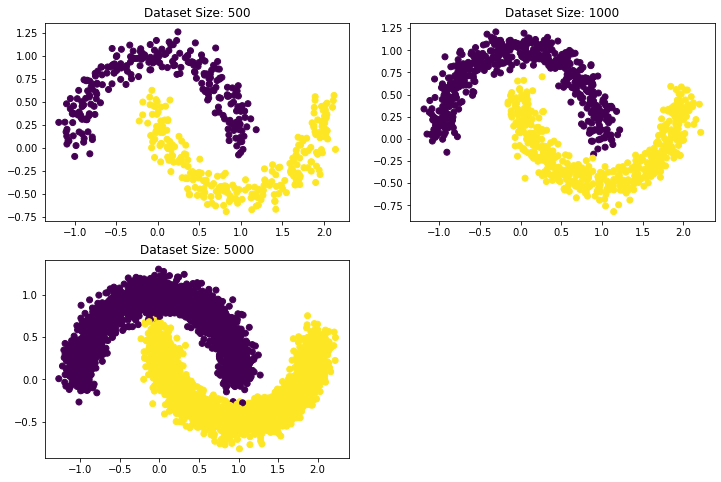

In [28]:
dataset_sizes = [500, 1000, 5000]

# Generate datasets of varying sizes
train_datasets = {}
val_datasets = {}
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {"X": X, "y": y}
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    train_datasets[size] = {"X": torch.FloatTensor(X_train), "y": y_train}
    val_datasets[size] = {"X": torch.FloatTensor(X_test), "y": y_test}

# Visualize the training datasets
plt.figure(figsize=(12, 8))

for i, size in enumerate(dataset_sizes, 1):
    plt.subplot(2, 2, i)
    plt.scatter(
        datasets[size]["X"][:, 0], datasets[size]["X"][:, 1], c=datasets[size]["y"]
    )
    plt.title(f"Dataset Size: {size}")

plt.show()

Next we implement the Autoencoder class with variable length of hidden layers

In [3]:
# Autoencoder model class
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()

        encoder_layers = []
        decoder_layers = []

        encoder_layers.append(nn.Linear(input_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(bottleneck_size, hidden_size))
        decoder_layers.append(nn.ReLU())

        # Encoder and Decoder layers
        for _ in range(layers):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))
        decoder_layers.append(nn.Linear(hidden_size, input_size))

        # Combine encoder and decoder
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Lets define the training and testing function with the demanded parameters

In [34]:
# Training function
def train_autoencoder(
    model,
    train_datasets,
    val_datasets,
    dataset_size=1000,
    num_epochs=100,
    batch_size=32,
    learning_rate=0.001,
):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Data loader

    train_loader = torch.utils.data.DataLoader(
        train_datasets[dataset_size]["X"], batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_datasets[dataset_size]["X"], batch_size=batch_size, shuffle=True
    )

    epoch_train_losses = []  # List to store the loss for each epoch
    epoch_val_losses = []  # List to store the loss for each epoch
    for epoch in range(num_epochs):
        train_batch_losses = []
        val_batch_losses = []
        for batch in train_loader:
            # Forward pass
            outputs = model(batch)

            # Compute the loss
            loss = criterion(outputs, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item())

        for batch in val_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch)
            val_batch_losses.append(loss.item())

        # Calculate and store the mean loss for the epoch
        epoch_train_loss = sum(train_batch_losses) / len(train_batch_losses)
        epoch_train_losses.append(epoch_train_loss)

        epoch_val_loss = sum(val_batch_losses) / len(val_batch_losses)
        epoch_val_losses.append(epoch_val_loss)
        # Print the mean loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}")
    return epoch_train_losses, epoch_val_losses

Checking training functionality:

In [24]:
# Create and train the autoencoder
input_size = 2
bottleneck_size = 1
hidden_size = 100
layers = 2
dataset_size = 1000


autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size, layers)
_, _ = train_autoencoder(autoencoder, train_datasets, dataset_size=1000, num_epochs=200)

Epoch [10/200], Loss: 2.5318
Epoch [20/200], Loss: 0.6555
Epoch [30/200], Loss: 0.3839
Epoch [40/200], Loss: 0.2662
Epoch [50/200], Loss: 0.2075
Epoch [60/200], Loss: 0.1883
Epoch [70/200], Loss: 0.1771
Epoch [80/200], Loss: 0.1527
Epoch [90/200], Loss: 0.1442
Epoch [100/200], Loss: 0.1340
Epoch [110/200], Loss: 0.1357
Epoch [120/200], Loss: 0.1355
Epoch [130/200], Loss: 0.1306
Epoch [140/200], Loss: 0.1286
Epoch [150/200], Loss: 0.1323
Epoch [160/200], Loss: 0.1316
Epoch [170/200], Loss: 0.1257
Epoch [180/200], Loss: 0.1424
Epoch [190/200], Loss: 0.1290
Epoch [200/200], Loss: 0.1280
Mean squared reconstruction loss on test dataset: 0.008382718078792095


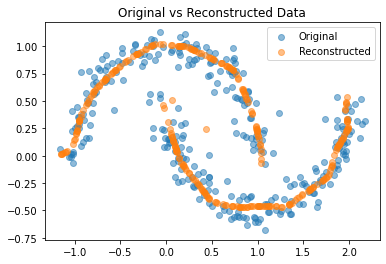

In [6]:
# Function to visualize original and reconstructed data
def visualize_results(model, data):
    with torch.no_grad():
        reconstructed_data = model(data)

    # Convert PyTorch tensors to numpy arrays
    data_np = data.numpy()
    reconstructed_np = reconstructed_data.numpy()

    # Plot original and reconstructed data
    plt.scatter(data_np[:, 0], data_np[:, 1], label="Original", alpha=0.5)
    plt.scatter(
        reconstructed_np[:, 0], reconstructed_np[:, 1], label="Reconstructed", alpha=0.5
    )
    plt.title("Original vs Reconstructed Data")
    plt.legend()
    plt.show()


# Visualize results on the test dataset
visualize_results(autoencoder, val_datasets[dataset_size]["X"])

## 1.1 Hyperparameter search
In order to not a have a exploding search space, we first analyze the number of epochs in relation to the dataset size

In [47]:
# Define the hyperparameter values to explore
hidden_sizes = [50, 100, 200]
layers = [2, 5, 10]
learning_rates = [0.0005, 0.001, 0.002, 0.003]
epochs = [100, 250, 500]
dataset_sizes = [500, 1000, 5000]

Epoch [10/400], Loss: 0.0627
Epoch [20/400], Loss: 0.0409
Epoch [30/400], Loss: 0.0375
Epoch [40/400], Loss: 0.0314
Epoch [50/400], Loss: 0.0245
Epoch [60/400], Loss: 0.0161
Epoch [70/400], Loss: 0.0148
Epoch [80/400], Loss: 0.0097
Epoch [90/400], Loss: 0.0077
Epoch [100/400], Loss: 0.0090
Epoch [110/400], Loss: 0.0107
Epoch [120/400], Loss: 0.0075
Epoch [130/400], Loss: 0.0070
Epoch [140/400], Loss: 0.0076
Epoch [150/400], Loss: 0.0073
Epoch [160/400], Loss: 0.0067
Epoch [170/400], Loss: 0.0062
Epoch [180/400], Loss: 0.0071
Epoch [190/400], Loss: 0.0061
Epoch [200/400], Loss: 0.0062
Epoch [210/400], Loss: 0.0073
Epoch [220/400], Loss: 0.0070
Epoch [230/400], Loss: 0.0069
Epoch [240/400], Loss: 0.0059
Epoch [250/400], Loss: 0.0065
Epoch [260/400], Loss: 0.0062
Epoch [270/400], Loss: 0.0063
Epoch [280/400], Loss: 0.0059
Epoch [290/400], Loss: 0.0057
Epoch [300/400], Loss: 0.0059
Epoch [310/400], Loss: 0.0060
Epoch [320/400], Loss: 0.0063
Epoch [330/400], Loss: 0.0057
Epoch [340/400], Lo

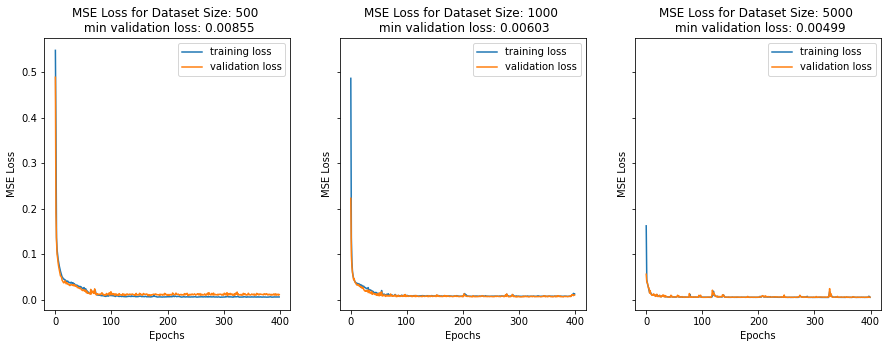

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, dataset_size in enumerate(dataset_sizes):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size=100, layers=2)
    train_losses, val_losses = train_autoencoder(
        autoencoder,
        train_datasets,
        val_datasets,
        dataset_size=dataset_size,
        num_epochs=400,
    )
    axes[i].plot(train_losses, label="training loss")
    axes[i].plot(val_losses, label="validation loss")
    axes[i].set_title(
        "MSE Loss for Dataset Size: {} \n min validation loss: {:.5f}".format(
            dataset_size, min(val_losses)
        )
    )
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("MSE Loss")
    axes[i].legend()

The best performance is achieved for the biggest dataset, however the dataset with 1000 entries is almost just as good and substantially faster. Therefore, we choose the continue with this medium sized dataset and let the training run to 200 epochs for now

Epoch [10/300], Loss: 0.0442
Epoch [20/300], Loss: 0.0336
Epoch [30/300], Loss: 0.0310
Epoch [40/300], Loss: 0.0282
Epoch [50/300], Loss: 0.0202
Epoch [60/300], Loss: 0.0155
Epoch [70/300], Loss: 0.0144
Epoch [80/300], Loss: 0.0124
Epoch [90/300], Loss: 0.0114
Epoch [100/300], Loss: 0.0098
Epoch [110/300], Loss: 0.0094
Epoch [120/300], Loss: 0.0089
Epoch [130/300], Loss: 0.0094
Epoch [140/300], Loss: 0.0088
Epoch [150/300], Loss: 0.0095
Epoch [160/300], Loss: 0.0077
Epoch [170/300], Loss: 0.0077
Epoch [180/300], Loss: 0.0078
Epoch [190/300], Loss: 0.0095
Epoch [200/300], Loss: 0.0089
Epoch [210/300], Loss: 0.0080
Epoch [220/300], Loss: 0.0073
Epoch [230/300], Loss: 0.0072
Epoch [240/300], Loss: 0.0076
Epoch [250/300], Loss: 0.0078
Epoch [260/300], Loss: 0.0074
Epoch [270/300], Loss: 0.0077
Epoch [280/300], Loss: 0.0075
Epoch [290/300], Loss: 0.0075
Epoch [300/300], Loss: 0.0073
Epoch [10/300], Loss: 0.0368
Epoch [20/300], Loss: 0.0291
Epoch [30/300], Loss: 0.0219
Epoch [40/300], Loss: 

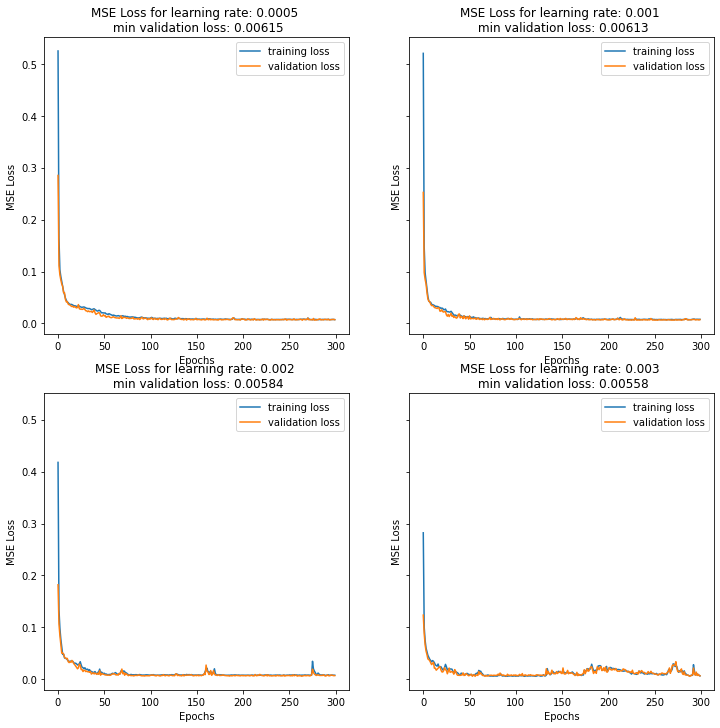

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
for i, learning_rate in enumerate(learning_rates):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size=100, layers=2)
    train_losses, val_losses = train_autoencoder(
        autoencoder,
        train_datasets,
        val_datasets,
        dataset_size=1000,
        num_epochs=300,
        learning_rate=learning_rate,
    )

    # Use two indices to access the correct subplot
    row = i // 2  # Integer division to get the row index
    col = i % 2  # Modulo operation to get the column index

    axes[row, col].plot(train_losses, label="training loss")
    axes[row, col].plot(val_losses, label="validation loss")
    axes[row, col].set_title(
        "MSE Loss for learning rate: {} \n min validation loss: {:.5f}".format(
            learning_rate, min(val_losses)
        )
    )
    axes[row, col].set_xlabel("Epochs")
    axes[row, col].set_ylabel("MSE Loss")
    axes[row, col].legend()

We see, with this autoencoder architecture, the learning rate does not have a great impact on training results. Nevertheless, training with larger learning rates is faster but we one can see, that the training is more unstable as well. Thus, we continue with a learning rate of 0.001 for 200 epochs. Now lets see, if we can improve the network hyperparameters

Epoch [10/200], Loss: 0.0534
Epoch [20/200], Loss: 0.0364
Epoch [30/200], Loss: 0.0313
Epoch [40/200], Loss: 0.0271
Epoch [50/200], Loss: 0.0220
Epoch [60/200], Loss: 0.0175
Epoch [70/200], Loss: 0.0146
Epoch [80/200], Loss: 0.0121
Epoch [90/200], Loss: 0.0113
Epoch [100/200], Loss: 0.0120
Epoch [110/200], Loss: 0.0093
Epoch [120/200], Loss: 0.0091
Epoch [130/200], Loss: 0.0094
Epoch [140/200], Loss: 0.0084
Epoch [150/200], Loss: 0.0087
Epoch [160/200], Loss: 0.0085
Epoch [170/200], Loss: 0.0080
Epoch [180/200], Loss: 0.0087
Epoch [190/200], Loss: 0.0080
Epoch [200/200], Loss: 0.0083
Epoch [10/200], Loss: 0.0694
Epoch [20/200], Loss: 0.0517
Epoch [30/200], Loss: 0.0366
Epoch [40/200], Loss: 0.0279
Epoch [50/200], Loss: 0.0237
Epoch [60/200], Loss: 0.0216
Epoch [70/200], Loss: 0.0192
Epoch [80/200], Loss: 0.0196
Epoch [90/200], Loss: 0.0196
Epoch [100/200], Loss: 0.0151
Epoch [110/200], Loss: 0.0162
Epoch [120/200], Loss: 0.0089
Epoch [130/200], Loss: 0.0078
Epoch [140/200], Loss: 0.007

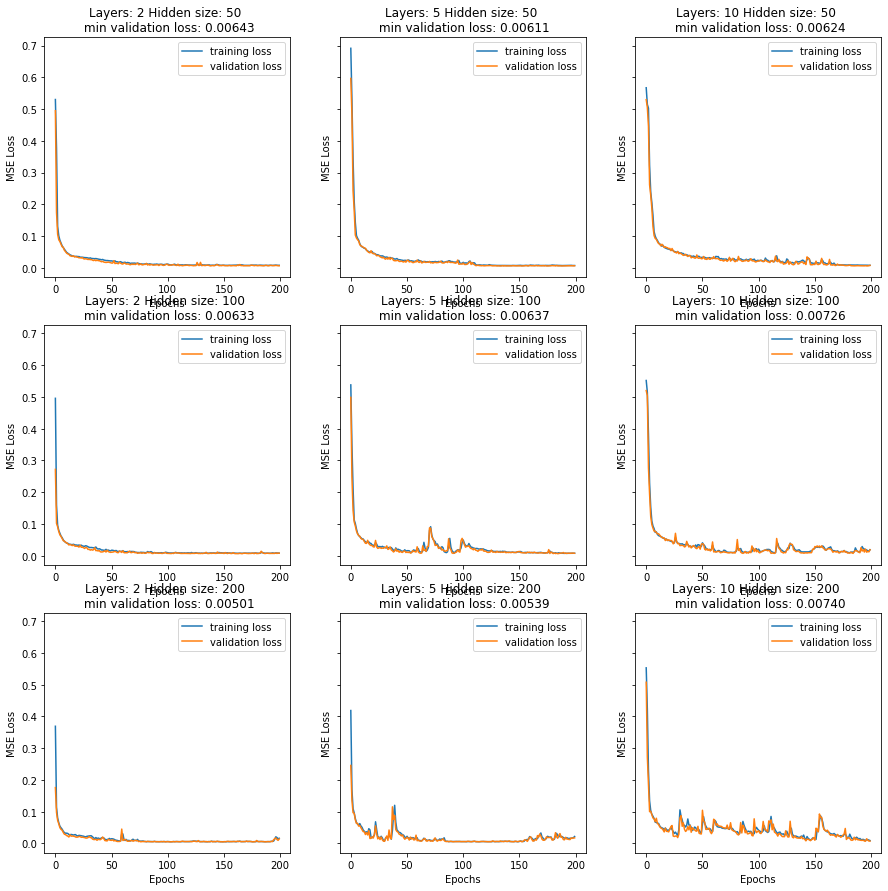

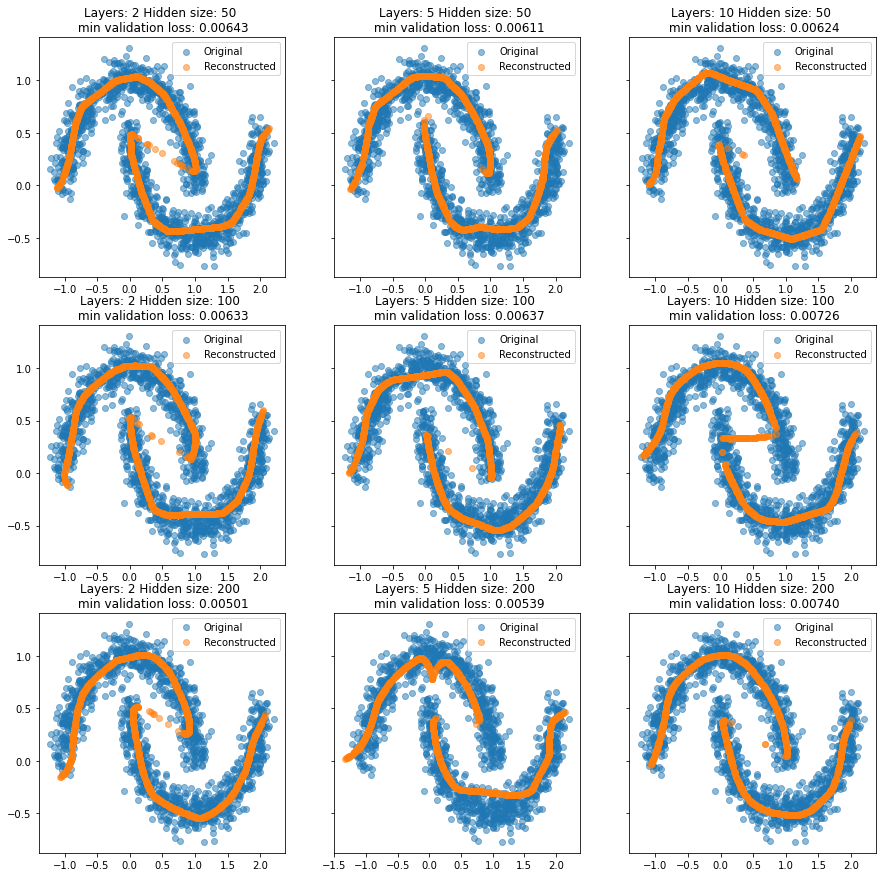

In [54]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
fig_2, axes_2 = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

for i, hidden_size in enumerate(hidden_sizes):
    for j, num_layers in enumerate(layers):
        autoencoder = Autoencoder(
            input_size, bottleneck_size, hidden_size=hidden_size, layers=num_layers
        )
        train_losses, val_losses = train_autoencoder(
            autoencoder,
            train_datasets,
            val_datasets,
            dataset_size=1000,
            num_epochs=200,
            learning_rate=0.001,
        )

        axes[i, j].plot(train_losses, label="training loss")
        axes[i, j].plot(val_losses, label="validation loss")
        axes[i, j].set_title(
            "Layers: {} Hidden size: {} \n min validation loss: {:.5f}".format(
                num_layers, hidden_size, min(val_losses)
            )
        )
        axes[i, j].set_xlabel("Epochs")
        axes[i, j].set_ylabel("MSE Loss")
        axes[i, j].legend()

        val_data = val_datasets[dataset_size]["X"]
        with torch.no_grad():
            reconstructed_data = autoencoder(val_data)

        # Convert PyTorch tensors to numpy arrays
        data_np = val_data.numpy()
        reconstructed_np = reconstructed_data.numpy()

        # Plot original and reconstructed data
        axes_2[i, j].scatter(data_np[:, 0], data_np[:, 1], label="Original", alpha=0.5)
        axes_2[i, j].scatter(
            reconstructed_np[:, 0],
            reconstructed_np[:, 1],
            label="Reconstructed",
            alpha=0.5,
        )
        axes_2[i, j].set_title(
            "Layers: {} Hidden size: {} \n min validation loss: {:.5f}".format(
                num_layers, hidden_size, min(val_losses)
            )
        )
        axes_2[i, j].legend()

Epoch [10/150], Loss: 0.0614
Epoch [20/150], Loss: 0.0370
Epoch [30/150], Loss: 0.0332
Epoch [40/150], Loss: 0.0302
Epoch [50/150], Loss: 0.0280
Epoch [60/150], Loss: 0.0221
Epoch [70/150], Loss: 0.0166
Epoch [80/150], Loss: 0.0135
Epoch [90/150], Loss: 0.0118
Epoch [100/150], Loss: 0.0109
Epoch [110/150], Loss: 0.0110
Epoch [120/150], Loss: 0.0093
Epoch [130/150], Loss: 0.0090
Epoch [140/150], Loss: 0.0091
Epoch [150/150], Loss: 0.0089
Epoch [10/150], Loss: 0.0758
Epoch [20/150], Loss: 0.0527
Epoch [30/150], Loss: 0.0411
Epoch [40/150], Loss: 0.0302
Epoch [50/150], Loss: 0.0261
Epoch [60/150], Loss: 0.0188
Epoch [70/150], Loss: 0.0156
Epoch [80/150], Loss: 0.0109
Epoch [90/150], Loss: 0.0113
Epoch [100/150], Loss: 0.0096
Epoch [110/150], Loss: 0.0130
Epoch [120/150], Loss: 0.0182
Epoch [130/150], Loss: 0.0130
Epoch [140/150], Loss: 0.0068
Epoch [150/150], Loss: 0.0059
Epoch [10/150], Loss: 0.0803
Epoch [20/150], Loss: 0.0549
Epoch [30/150], Loss: 0.0393
Epoch [40/150], Loss: 0.0308
Ep

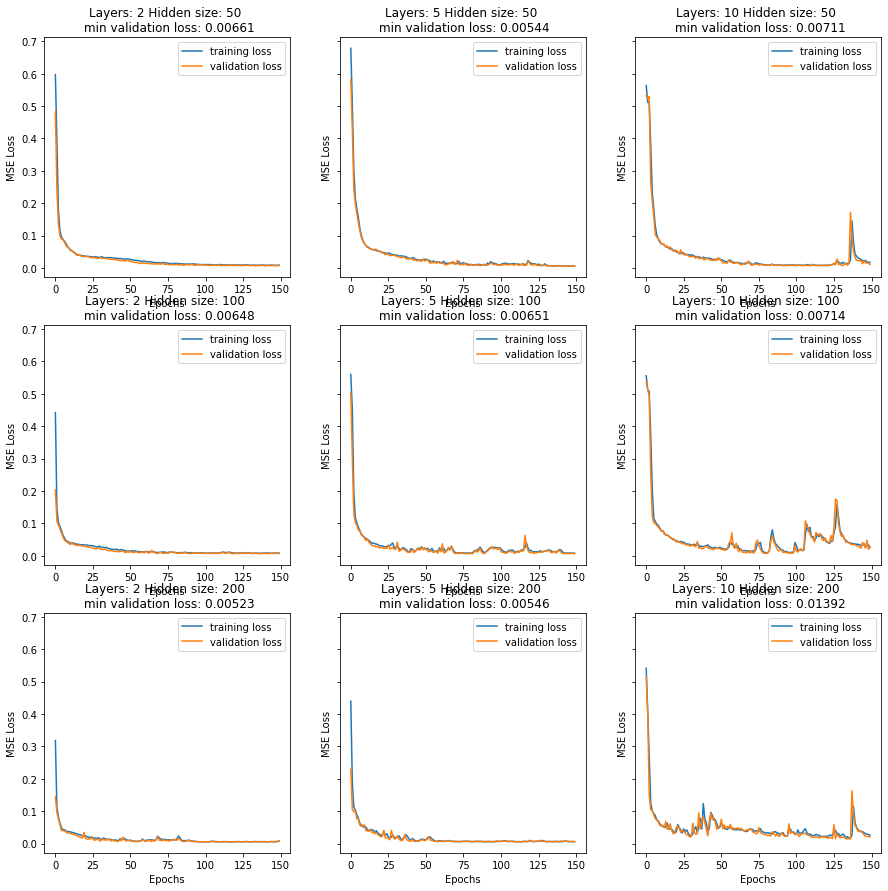

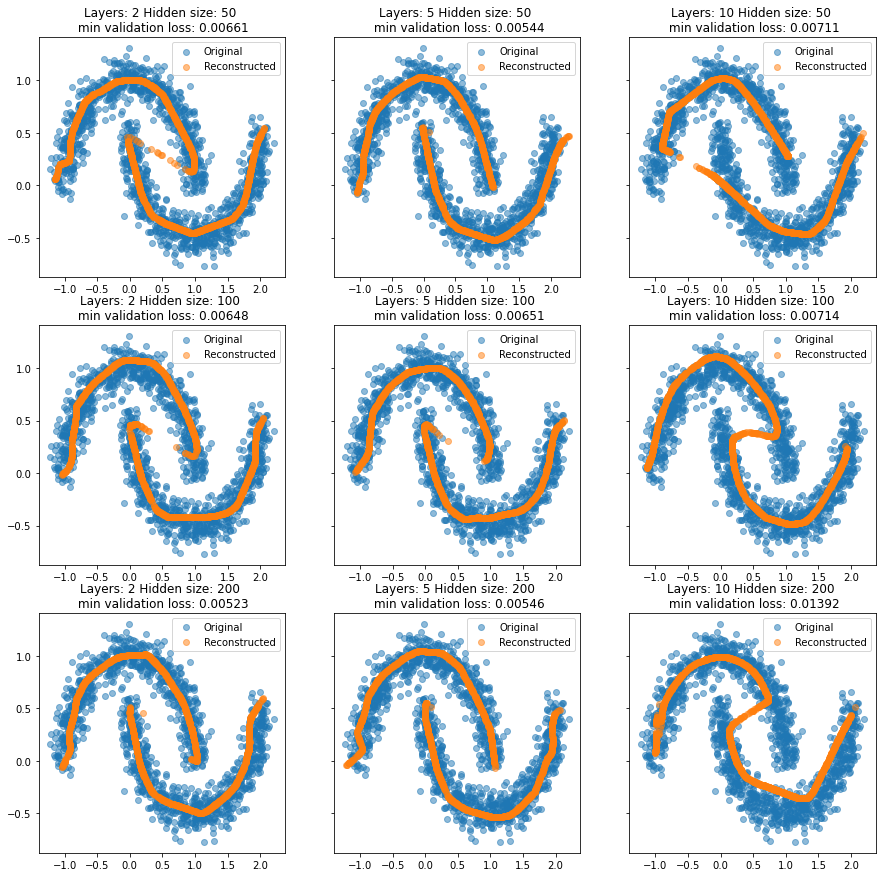

In [61]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
fig_2, axes_2 = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

for i, hidden_size in enumerate(hidden_sizes):
    for j, num_layers in enumerate(layers):
        autoencoder = Autoencoder(
            input_size, bottleneck_size, hidden_size=hidden_size, layers=num_layers
        )
        train_losses, val_losses = train_autoencoder(
            autoencoder,
            train_datasets,
            val_datasets,
            dataset_size=1000,
            num_epochs=150,
            learning_rate=0.001,
        )

        axes[i, j].plot(train_losses, label="training loss")
        axes[i, j].plot(val_losses, label="validation loss")
        axes[i, j].set_title(
            "Layers: {} Hidden size: {} \n min validation loss: {:.5f}".format(
                num_layers, hidden_size, min(val_losses)
            )
        )
        axes[i, j].set_xlabel("Epochs")
        axes[i, j].set_ylabel("MSE Loss")
        axes[i, j].legend()

        val_data = val_datasets[dataset_size]["X"]
        with torch.no_grad():
            reconstructed_data = autoencoder(val_data)

        # Convert PyTorch tensors to numpy arrays
        data_np = val_data.numpy()
        reconstructed_np = reconstructed_data.numpy()

        # Plot original and reconstructed data
        axes_2[i, j].scatter(data_np[:, 0], data_np[:, 1], label="Original", alpha=0.5)
        axes_2[i, j].scatter(
            reconstructed_np[:, 0],
            reconstructed_np[:, 1],
            label="Reconstructed",
            alpha=0.5,
        )
        axes_2[i, j].set_title(
            "Layers: {} Hidden size: {} \n min validation loss: {:.5f}".format(
                num_layers, hidden_size, min(val_losses)
            )
        )
        axes_2[i, j].legend()

## 2.2
Repeating the same trainig with all dataset sizes

Epoch [10/150], Loss: 0.0481
Epoch [20/150], Loss: 0.0362
Epoch [30/150], Loss: 0.0299
Epoch [40/150], Loss: 0.0251
Epoch [50/150], Loss: 0.0148
Epoch [60/150], Loss: 0.0129
Epoch [70/150], Loss: 0.0149
Epoch [80/150], Loss: 0.0100
Epoch [90/150], Loss: 0.0100
Epoch [100/150], Loss: 0.0086
Epoch [110/150], Loss: 0.0094
Epoch [120/150], Loss: 0.0091
Epoch [130/150], Loss: 0.0080
Epoch [140/150], Loss: 0.0073
Epoch [150/150], Loss: 0.0068
Epoch [10/150], Loss: 0.0360
Epoch [20/150], Loss: 0.0245
Epoch [30/150], Loss: 0.0197
Epoch [40/150], Loss: 0.0156
Epoch [50/150], Loss: 0.0117
Epoch [60/150], Loss: 0.0096
Epoch [70/150], Loss: 0.0089
Epoch [80/150], Loss: 0.0080
Epoch [90/150], Loss: 0.0127
Epoch [100/150], Loss: 0.0082
Epoch [110/150], Loss: 0.0082
Epoch [120/150], Loss: 0.0132
Epoch [130/150], Loss: 0.0098
Epoch [140/150], Loss: 0.0068
Epoch [150/150], Loss: 0.0058
Epoch [10/150], Loss: 0.0130
Epoch [20/150], Loss: 0.0086
Epoch [30/150], Loss: 0.0156
Epoch [40/150], Loss: 0.0086
Ep

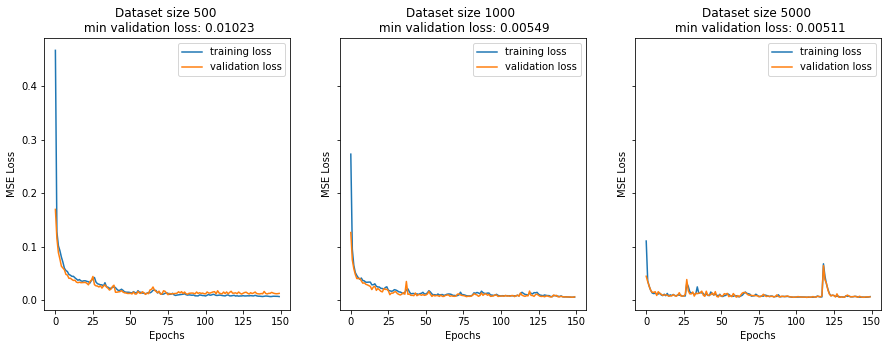

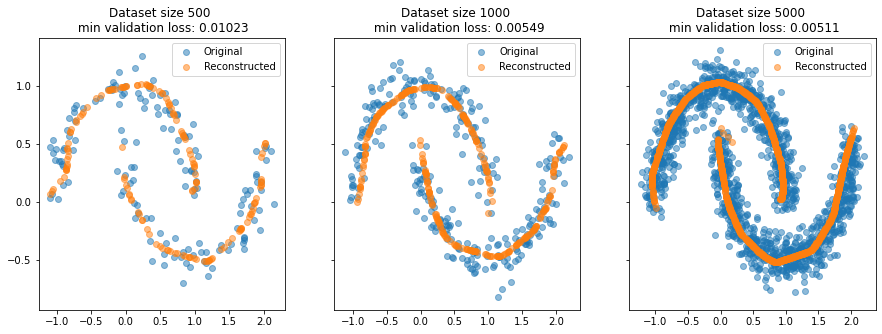

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig_2, axes_2 = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, dataset_size in enumerate(dataset_sizes):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size=200, layers=2)
    train_losses, val_losses = train_autoencoder(
        autoencoder,
        train_datasets,
        val_datasets,
        dataset_size=dataset_size,
        num_epochs=150,
        learning_rate=0.001,
    )

    axes[i].plot(train_losses, label="training loss")
    axes[i].plot(val_losses, label="validation loss")
    axes[i].set_title(
        "Dataset size {} \n min validation loss: {:.5f}".format(
            dataset_size, min(val_losses)
        )
    )
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("MSE Loss")
    axes[i].legend()

    val_data = val_datasets[dataset_size]["X"]
    with torch.no_grad():
        reconstructed_data = autoencoder(val_data)

    # Convert PyTorch tensors to numpy arrays
    data_np = val_data.numpy()
    reconstructed_np = reconstructed_data.numpy()

    # Plot original and reconstructed data
    axes_2[i].scatter(data_np[:, 0], data_np[:, 1], label="Original", alpha=0.5)
    axes_2[i].scatter(
        reconstructed_np[:, 0], reconstructed_np[:, 1], label="Reconstructed", alpha=0.5
    )
    axes_2[i].set_title(
        "Dataset size {} \n min validation loss: {:.5f}".format(
            dataset_size, min(val_losses)
        )
    )
    axes_2[i].legend()

unsuspectedly the resuts are quite good for all dataset size. But one can see, that the training doesnt need as many epoch with the large dataset and already started to be incoherant

## 2.3
Visualization of code distribution with histogram

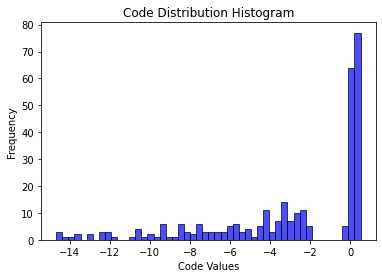

In [110]:
from sklearn.mixture import GaussianMixture
import numpy as np

val_loader = torch.utils.data.DataLoader(
    val_datasets[1000]["X"], batch_size=1, shuffle=True
)
autoencoder.eval()

# Create empty list to store code representations
code_list = []
reconstructed_data = []

# Iterate over batches in the test dataset and extract code representations
with torch.no_grad():
    for data in val_loader:
        outputs = autoencoder.encoder(data)
        reconstructed = autoencoder(data)
        code_list.append(outputs.numpy())
        reconstructed_data.append(reconstructed.numpy())

# Concatenate code representations from all batches
all_codes = np.concatenate(code_list, axis=0)
reconstructed_data = np.stack(reconstructed_data)
reconstructed_data = np.squeeze(reconstructed_data)

# Visualize histogram
plt.hist(all_codes, bins=50, alpha=0.7, color="blue", edgecolor="black")
plt.title("Code Distribution Histogram")
plt.xlabel("Code Values")
plt.ylabel("Frequency")
plt.show()

c:\Users\luke\anaconda3\envs\ml_homework\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


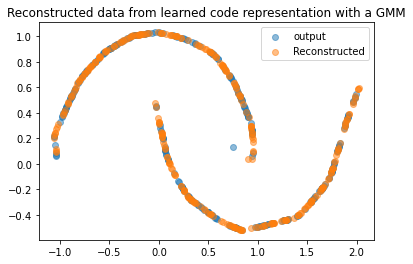

In [111]:
n_components = 20
gmm = GaussianMixture(n_components=n_components)
gmm.fit(all_codes)
new_samples, _ = gmm.sample(len(all_codes))
new_samples = torch.tensor(new_samples, dtype=torch.float32)
output_data = []
for i in range(len(all_codes)):
    output = autoencoder.decoder(new_samples[i])
    output_data.append(output.detach().numpy())

output_data = np.stack(output_data, axis=0)

plt.scatter(output_data[:, 0], output_data[:, 1], label="output", alpha=0.5)
plt.scatter(
    reconstructed_data[:, 0], reconstructed_data[:, 1], label="Reconstructed", alpha=0.5
)
plt.title("Reconstructed data from learned code representation with a GMM")
plt.legend()

The GMM menages to learn the code representation of the Autoencoder successfully, thus the autoencoder is able the reconstruct the distributions from the sampled code representations

## 2.4


In [118]:
dataset_size = 1000
new_X, new_y = make_moons(n_samples=dataset_size, noise=0.2)
X_train, X_test, y_train, y_test = train_test_split(
    new_X, new_y, test_size=0.3, random_state=42
)
new_data = new_X
new_train_dataset = {}
new_val_dataset = {}
new_train_dataset[dataset_size] = {"X": torch.FloatTensor(X_train), "y": y_train}
new_val_dataset[dataset_size] = {"X": torch.FloatTensor(X_test), "y": y_test}

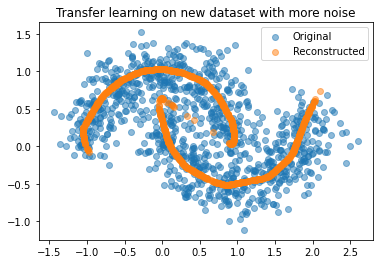

In [119]:
inputs = torch.tensor(new_data, dtype=torch.float32)
with torch.no_grad():
    reconstructed_data = autoencoder(inputs)

# Convert PyTorch tensors to numpy arrays
reconstructed_np = reconstructed_data.numpy()

# Plot original and reconstructed data
plt.scatter(new_data[:, 0], new_data[:, 1], label="Original", alpha=0.5)
plt.scatter(
    reconstructed_np[:, 0], reconstructed_np[:, 1], label="Reconstructed", alpha=0.5
)
plt.title("Transfer learning on new dataset with more noise")
plt.legend()

The Autoencoder is able to detect the rough shape but the reconstuction in the middle between the half moons isn't as great

## 2.5


Epoch [10/150], Loss: 0.0509
Epoch [20/150], Loss: 0.0384
Epoch [30/150], Loss: 0.0346
Epoch [40/150], Loss: 0.0329
Epoch [50/150], Loss: 0.0298
Epoch [60/150], Loss: 0.0276
Epoch [70/150], Loss: 0.0259
Epoch [80/150], Loss: 0.0287
Epoch [90/150], Loss: 0.0245
Epoch [100/150], Loss: 0.0254
Epoch [110/150], Loss: 0.0235
Epoch [120/150], Loss: 0.0230
Epoch [130/150], Loss: 0.0233
Epoch [140/150], Loss: 0.0238
Epoch [150/150], Loss: 0.0240


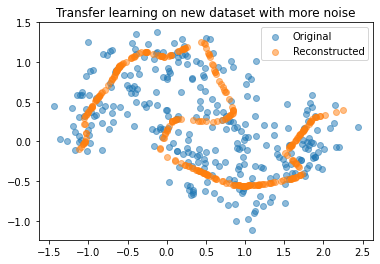

In [120]:
autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size=200, layers=2)
train_losses, val_losses = train_autoencoder(
    autoencoder,
    new_train_dataset,
    new_val_dataset,
    dataset_size=dataset_size,
    num_epochs=150,
    learning_rate=0.001,
)

val_data = new_val_dataset[dataset_size]["X"]
with torch.no_grad():
    reconstructed_data = autoencoder(val_data)

# Convert PyTorch tensors to numpy arrays
data_np = val_data.numpy()
reconstructed_np = reconstructed_data.numpy()

# Plot original and reconstructed data
plt.scatter(data_np[:, 0], data_np[:, 1], label="Original", alpha=0.5)
plt.scatter(
    reconstructed_np[:, 0], reconstructed_np[:, 1], label="Reconstructed", alpha=0.5
)
plt.title("Transfer learning on new dataset with more noise")
plt.legend()

The training with the same learning parameters performs now worse and the autoencoder is not able to reconstruct the correct shape entirely

# 3 Higher-dimensional data

In [142]:
from sklearn.datasets import load_digits

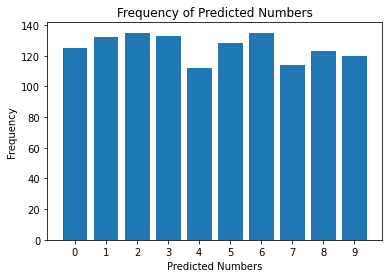

In [143]:
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.3
)
train_dataset = {"X": torch.FloatTensor(X_train), "y": y_train}
val_dataset = {"X": torch.FloatTensor(X_test), "y": y_test}

# Count the frequency of each number from 0 to 9 in y_pred_gauss
count = np.bincount(y_train)

# Create a bar chart to visualize the frequencies
plt.bar(range(10), count)
plt.xticks(range(10))
plt.xlabel("Predicted Numbers")
plt.ylabel("Frequency")
plt.title("Frequency of Predicted Numbers")
plt.show()

In [144]:
# Training function
def train_autoencoder(
    model,
    train_dataset,
    test_dataset,
    dataset_size=1.0,
    num_epochs=100,
    batch_size=32,
    learning_rate=0.001,
):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    X_train = train_dataset["X"]
    X_test = test_dataset["X"]

    if dataset_size < 1.0:
        X_train, _ = train_test_split(X_train, test_size=1 - dataset_size)

    # Data loader
    train_loader = torch.utils.data.DataLoader(
        X_train, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        X_test, batch_size=batch_size, shuffle=True
    )

    epoch_train_losses = []  # List to store the loss for each epoch
    epoch_val_losses = []  # List to store the loss for each epoch
    for epoch in range(num_epochs):
        train_batch_losses = []
        val_batch_losses = []
        for batch in train_loader:
            # Forward pass
            outputs = model(batch)

            # Compute the loss
            loss = criterion(outputs, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item())

        for batch in val_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch)
            val_batch_losses.append(loss.item())

        # Calculate and store the mean loss for the epoch
        epoch_train_loss = sum(train_batch_losses) / len(train_batch_losses)
        epoch_train_losses.append(epoch_train_loss)

        epoch_val_loss = sum(val_batch_losses) / len(val_batch_losses)
        epoch_val_losses.append(epoch_val_loss)
        # Print the mean loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}")
    return epoch_train_losses, epoch_val_losses

Epoch [10/200], Loss: 18.4600
Epoch [20/200], Loss: 14.3314
Epoch [30/200], Loss: 10.7488
Epoch [40/200], Loss: 9.2260
Epoch [50/200], Loss: 7.8948
Epoch [60/200], Loss: 6.3145
Epoch [70/200], Loss: 5.4887
Epoch [80/200], Loss: 5.0071
Epoch [90/200], Loss: 4.6692
Epoch [100/200], Loss: 4.3920
Epoch [110/200], Loss: 4.1611
Epoch [120/200], Loss: 3.8126
Epoch [130/200], Loss: 3.6389
Epoch [140/200], Loss: 3.4762
Epoch [150/200], Loss: 3.2807
Epoch [160/200], Loss: 3.0617
Epoch [170/200], Loss: 3.0807
Epoch [180/200], Loss: 2.8661
Epoch [190/200], Loss: 2.6549
Epoch [200/200], Loss: 2.5009
Epoch [10/200], Loss: 15.5529
Epoch [20/200], Loss: 8.3709
Epoch [30/200], Loss: 6.5321
Epoch [40/200], Loss: 5.6199
Epoch [50/200], Loss: 5.2140
Epoch [60/200], Loss: 4.7185
Epoch [70/200], Loss: 4.4281
Epoch [80/200], Loss: 4.2409
Epoch [90/200], Loss: 3.9243
Epoch [100/200], Loss: 3.7587
Epoch [110/200], Loss: 3.6009
Epoch [120/200], Loss: 3.5346
Epoch [130/200], Loss: 3.3265
Epoch [140/200], Loss: 3

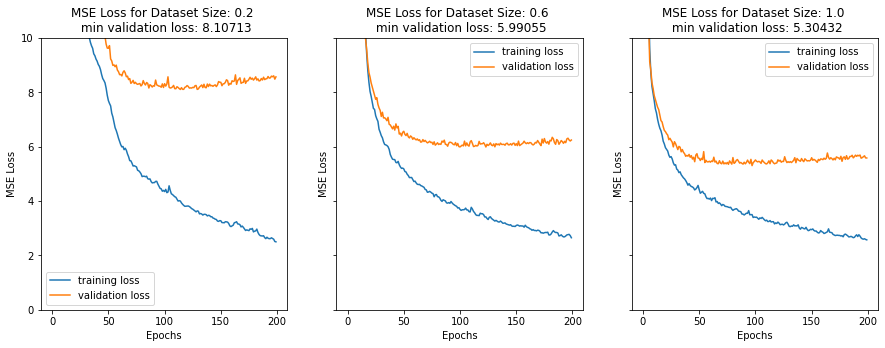

In [146]:
dataset_sizes = [0.2, 0.6, 1.0]  # Fraction of the original dataset size
input_size = 64
bottleneck_size = 4
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, dataset_size in enumerate(dataset_sizes):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size=200, layers=2)
    train_losses, val_losses = train_autoencoder(
        autoencoder,
        train_dataset,
        val_dataset,
        dataset_size=dataset_size,
        num_epochs=200,
    )
    axes[i].plot(train_losses, label="training loss")
    axes[i].plot(val_losses, label="validation loss")
    axes[i].set_title(
        "MSE Loss for Dataset Size: {} \n min validation loss: {:.5f}".format(
            dataset_size, min(val_losses)
        )
    )
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("MSE Loss")
    axes[i].set_ylim(0, 10)
    axes[i].legend()

We can see we are already overfitting the data at around 100 Epochs. The min validation loss was acieved by the full dataset, therefore we are going to persue with this one

Epoch [10/300], Loss: 10.3948
Epoch [20/300], Loss: 6.6469
Epoch [30/300], Loss: 5.7388
Epoch [40/300], Loss: 5.1717
Epoch [50/300], Loss: 4.7633
Epoch [60/300], Loss: 4.5159
Epoch [70/300], Loss: 4.2882
Epoch [80/300], Loss: 4.1495
Epoch [90/300], Loss: 4.0150
Epoch [100/300], Loss: 3.8533
Epoch [110/300], Loss: 3.7301
Epoch [120/300], Loss: 3.6201
Epoch [130/300], Loss: 3.5265
Epoch [140/300], Loss: 3.4207
Epoch [150/300], Loss: 3.3819
Epoch [160/300], Loss: 3.3100
Epoch [170/300], Loss: 3.2378
Epoch [180/300], Loss: 3.1446
Epoch [190/300], Loss: 3.0776
Epoch [200/300], Loss: 2.9946
Epoch [210/300], Loss: 2.9482
Epoch [220/300], Loss: 2.9546
Epoch [230/300], Loss: 2.8376
Epoch [240/300], Loss: 2.8415
Epoch [250/300], Loss: 2.7779
Epoch [260/300], Loss: 2.7497
Epoch [270/300], Loss: 2.7317
Epoch [280/300], Loss: 2.6884
Epoch [290/300], Loss: 2.6182
Epoch [300/300], Loss: 2.5940
Epoch [10/300], Loss: 9.4048
Epoch [20/300], Loss: 6.6952
Epoch [30/300], Loss: 5.7525
Epoch [40/300], Loss:

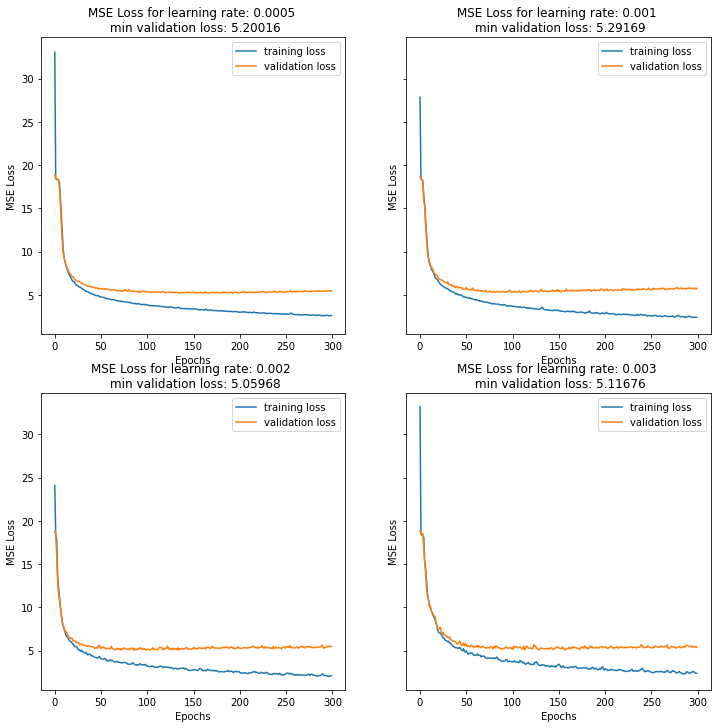

In [148]:
learning_rates = [0.0005, 0.001, 0.002, 0.003]
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
for i, learning_rate in enumerate(learning_rates):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size=200, layers=2)
    train_losses, val_losses = train_autoencoder(
        autoencoder,
        train_dataset,
        val_dataset,
        dataset_size=1.0,
        num_epochs=300,
        learning_rate=learning_rate,
    )

    # Use two indices to access the correct subplot
    row = i // 2  # Integer division to get the row index
    col = i % 2  # Modulo operation to get the column index

    axes[row, col].plot(train_losses, label="training loss")
    axes[row, col].plot(val_losses, label="validation loss")
    axes[row, col].set_title(
        "MSE Loss for learning rate: {} \n min validation loss: {:.5f}".format(
            learning_rate, min(val_losses)
        )
    )
    axes[row, col].set_xlabel("Epochs")
    axes[row, col].set_ylabel("MSE Loss")
    axes[row, col].legend()

The learning rate does not have a huge impact on the current architecture and we choose for now the best performung learning rate of 0.002. Next, we are going to look at different architectures, but with constant bottleneck size = 4 for now

Epoch [10/300], Loss: 16.4840
Epoch [20/300], Loss: 11.3524
Epoch [30/300], Loss: 9.7522
Epoch [40/300], Loss: 8.1971
Epoch [50/300], Loss: 7.2533
Epoch [60/300], Loss: 6.8407
Epoch [70/300], Loss: 6.5967
Epoch [80/300], Loss: 6.4128
Epoch [90/300], Loss: 6.0955
Epoch [100/300], Loss: 5.9026
Epoch [110/300], Loss: 5.7700
Epoch [120/300], Loss: 5.5504
Epoch [130/300], Loss: 5.5048
Epoch [140/300], Loss: 5.3809
Epoch [150/300], Loss: 5.3357
Epoch [160/300], Loss: 5.2326
Epoch [170/300], Loss: 5.1443
Epoch [180/300], Loss: 5.0627
Epoch [190/300], Loss: 4.9560
Epoch [200/300], Loss: 4.9804
Epoch [210/300], Loss: 4.8816
Epoch [220/300], Loss: 4.8901
Epoch [230/300], Loss: 4.8214
Epoch [240/300], Loss: 4.7185
Epoch [250/300], Loss: 4.6735
Epoch [260/300], Loss: 4.7438
Epoch [270/300], Loss: 4.6220
Epoch [280/300], Loss: 4.5778
Epoch [290/300], Loss: 4.6382
Epoch [300/300], Loss: 4.5190
Epoch [10/300], Loss: 18.2769
Epoch [20/300], Loss: 18.2546
Epoch [30/300], Loss: 18.2430
Epoch [40/300], L

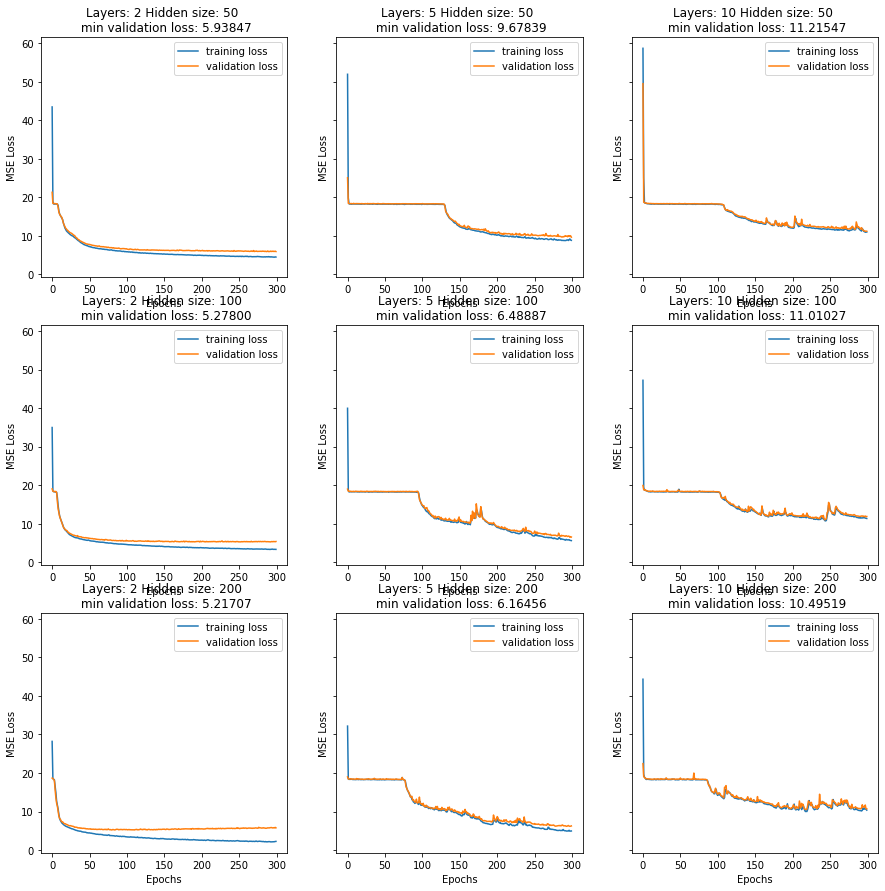

In [158]:
hidden_sizes = [50, 100, 200]
layers = [2, 5, 10]
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
for i, hidden_size in enumerate(hidden_sizes):
    for j, num_layers in enumerate(layers):

        autoencoder = Autoencoder(
            input_size, bottleneck_size, hidden_size=hidden_size, layers=num_layers
        )
        train_losses, val_losses = train_autoencoder(
            autoencoder,
            train_dataset,
            val_dataset,
            dataset_size=1.0,
            num_epochs=300,
            learning_rate=0.001,
        )

        axes[i, j].plot(train_losses, label="training loss")
        axes[i, j].plot(val_losses, label="validation loss")
        axes[i, j].set_title(
            "Layers: {} Hidden size: {} \n min validation loss: {:.5f}".format(
                num_layers, hidden_size, min(val_losses)
            )
        )
        axes[i, j].set_xlabel("Epochs")
        axes[i, j].set_ylabel("MSE Loss")
        axes[i, j].legend()

The tested network with 5 or 10 layers all have a strange plateo, where the loss is more or less constant and after around 60 epochs start improving again. It seems the best network structure from those which we have tested is again 2 layers and the biggest tested hidden size of 200, so lets test if a increased hidden size still improves the results

Epoch [10/70], Loss: 7.1132
Epoch [20/70], Loss: 5.4070
Epoch [30/70], Loss: 4.8553
Epoch [40/70], Loss: 4.3267
Epoch [50/70], Loss: 4.0164
Epoch [60/70], Loss: 3.6175
Epoch [70/70], Loss: 3.3985


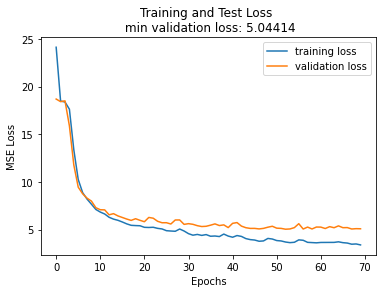

In [169]:
best_autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size=400, layers=2)
train_losses, val_losses = train_autoencoder(
    best_autoencoder,
    train_dataset,
    val_dataset,
    dataset_size=1.0,
    num_epochs=70,
    learning_rate=0.002,
)
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.title(
    "Training and Test Loss \n min validation loss: {:.5f}".format(min(val_losses))
)
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

The validation loss of this model with hidden size 400 is still platoing after around 100 epoch and the minimum validation loss is still around 5, but since the validation loss improved, we try a even bigger hidden size of 800

Epoch [10/200], Loss: 13.0530
Epoch [20/200], Loss: 6.2587
Epoch [30/200], Loss: 5.0509
Epoch [40/200], Loss: 4.6476
Epoch [50/200], Loss: 4.4377
Epoch [60/200], Loss: 4.1626
Epoch [70/200], Loss: 4.1874
Epoch [80/200], Loss: 3.7587
Epoch [90/200], Loss: 3.6998
Epoch [100/200], Loss: 3.6286
Epoch [110/200], Loss: 3.5767
Epoch [120/200], Loss: 3.5247
Epoch [130/200], Loss: 3.2418
Epoch [140/200], Loss: 3.1012
Epoch [150/200], Loss: 3.1125
Epoch [160/200], Loss: 3.0120
Epoch [170/200], Loss: 2.8734
Epoch [180/200], Loss: 2.8917
Epoch [190/200], Loss: 2.6362
Epoch [200/200], Loss: 2.5691


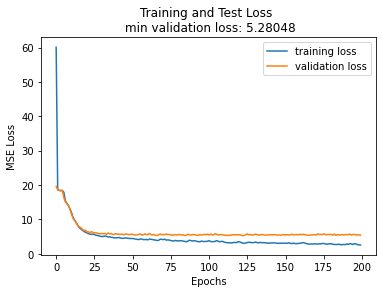

In [168]:
autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size=800, layers=2)
train_losses, val_losses = train_autoencoder(
    autoencoder,
    train_dataset,
    val_dataset,
    dataset_size=1.0,
    num_epochs=200,
    learning_rate=0.002,
)
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.title(
    "Training and Test Loss \n min validation loss: {:.5f}".format(min(val_losses))
)
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

Now we dont see any improvement anymore, so we stick with the model of 2 layers and hidden size of 400. Let finally plot some samples and look into the bottleneck size

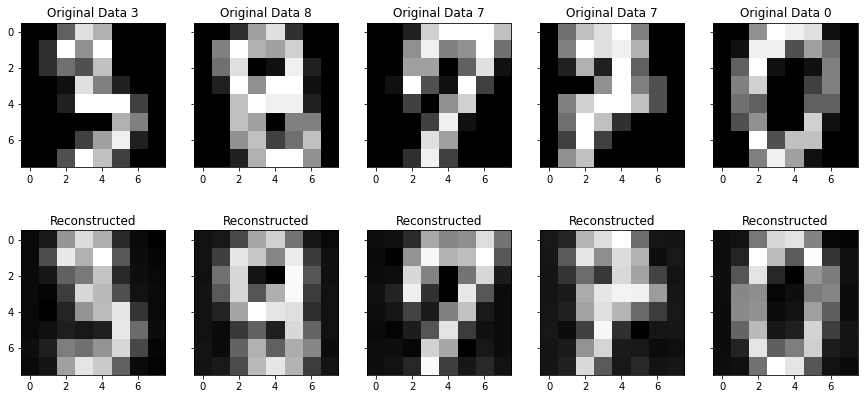

In [170]:
val_data = val_dataset["X"][:5]
val_labels = val_dataset["y"][:5]
with torch.no_grad():
    reconstructed_data = best_autoencoder(val_data)

# Convert PyTorch tensors to numpy arrays
data_np = val_data.numpy()
reconstructed_np = reconstructed_data.numpy()

fig, axes = plt.subplots(2, 5, figsize=(15, 7), sharey=True)
for k in range(5):
    axes[0, k].imshow(data_np[k].reshape(8, 8), cmap=plt.cm.gray)
    axes[0, k].set_title(f"Original Data {val_labels[k]}")
    axes[1, k].imshow(reconstructed_np[k].reshape(8, 8), cmap=plt.cm.gray)
    axes[1, k].set_title(f"Reconstructed")

plt.show()

The results are looking pretty good! Lets look into the influence of the bottleneck size

Epoch [10/200], Loss: 12.4592
Epoch [20/200], Loss: 11.0965
Epoch [30/200], Loss: 10.5375
Epoch [40/200], Loss: 9.7942
Epoch [50/200], Loss: 8.8697
Epoch [60/200], Loss: 8.5477
Epoch [70/200], Loss: 8.5726
Epoch [80/200], Loss: 8.2404
Epoch [90/200], Loss: 7.6579
Epoch [100/200], Loss: 7.4886
Epoch [110/200], Loss: 7.1685
Epoch [120/200], Loss: 6.8875
Epoch [130/200], Loss: 6.7129
Epoch [140/200], Loss: 6.3500
Epoch [150/200], Loss: 6.4551
Epoch [160/200], Loss: 5.7057
Epoch [170/200], Loss: 5.4821
Epoch [180/200], Loss: 5.3485
Epoch [190/200], Loss: 5.2245
Epoch [200/200], Loss: 5.1916


C:\Users\luke\AppData\Local\Temp\ipykernel_12092\2827622719.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_sub.show()


Epoch [10/200], Loss: 6.9690
Epoch [20/200], Loss: 5.3208
Epoch [30/200], Loss: 4.5750
Epoch [40/200], Loss: 4.1916
Epoch [50/200], Loss: 3.8340
Epoch [60/200], Loss: 3.5518
Epoch [70/200], Loss: 3.3979
Epoch [80/200], Loss: 3.2425
Epoch [90/200], Loss: 3.0083
Epoch [100/200], Loss: 2.8266
Epoch [110/200], Loss: 2.7763
Epoch [120/200], Loss: 2.7148
Epoch [130/200], Loss: 2.5763
Epoch [140/200], Loss: 2.5259
Epoch [150/200], Loss: 2.3964
Epoch [160/200], Loss: 2.3757
Epoch [170/200], Loss: 2.2138
Epoch [180/200], Loss: 2.1104
Epoch [190/200], Loss: 2.0981
Epoch [200/200], Loss: 1.9651
Epoch [10/200], Loss: 6.0441
Epoch [20/200], Loss: 3.7071
Epoch [30/200], Loss: 2.7195
Epoch [40/200], Loss: 2.1967
Epoch [50/200], Loss: 1.8577
Epoch [60/200], Loss: 1.6153
Epoch [70/200], Loss: 1.4481
Epoch [80/200], Loss: 1.3014
Epoch [90/200], Loss: 1.2099
Epoch [100/200], Loss: 1.1232
Epoch [110/200], Loss: 1.0713
Epoch [120/200], Loss: 0.9913
Epoch [130/200], Loss: 0.8700
Epoch [140/200], Loss: 0.850

C:\Users\luke\AppData\Local\Temp\ipykernel_12092\2827622719.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


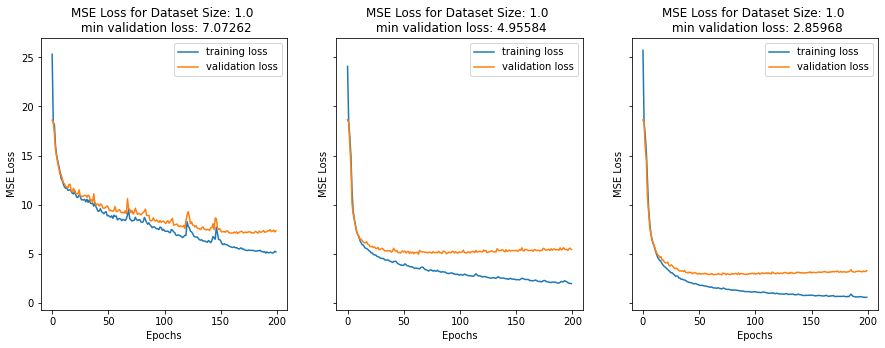

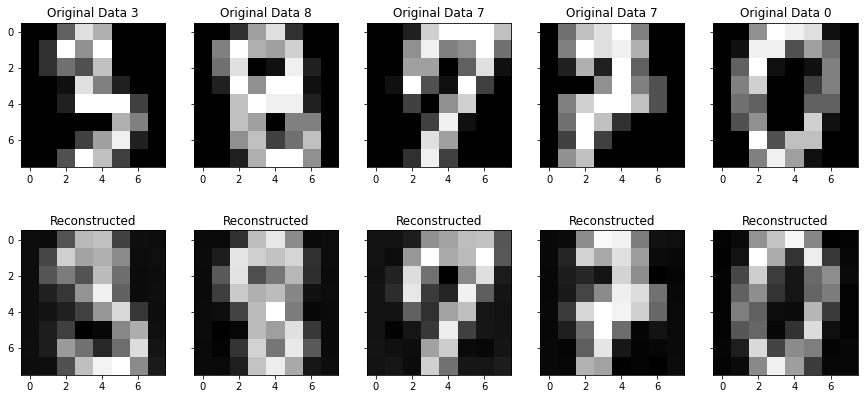

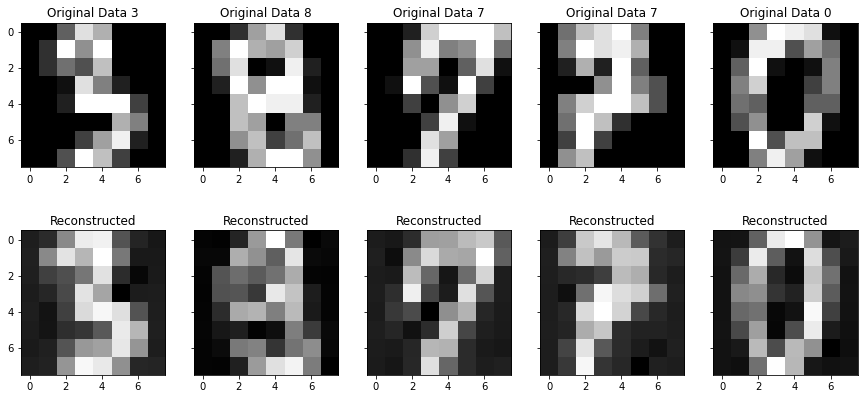

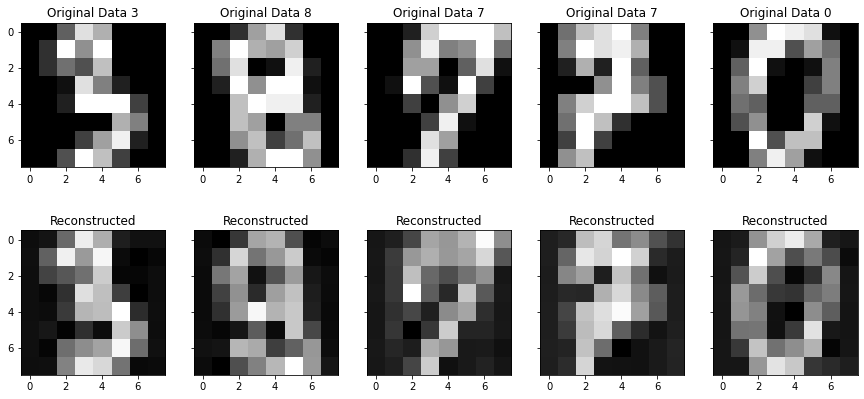

In [173]:
bottleneck_sizes = [2, 4, 8]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# Visualization subplot
val_data = val_dataset["X"][:5]
val_labels = val_dataset["y"][:5]

for i, bottleneck_size in enumerate(bottleneck_sizes):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size=400, layers=2)
    train_losses, val_losses = train_autoencoder(
        autoencoder,
        train_dataset,
        val_dataset,
        dataset_size=dataset_size,
        num_epochs=200,
    )
    axes[i].plot(train_losses, label="training loss")
    axes[i].plot(val_losses, label="validation loss")
    axes[i].set_title(
        "MSE Loss for Dataset Size: {} \n min validation loss: {:.5f}".format(
            dataset_size, min(val_losses)
        )
    )
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("MSE Loss")
    axes[i].legend()

    with torch.no_grad():
        reconstructed_data = autoencoder(val_data)

    # Convert PyTorch tensors to numpy arrays
    data_np = val_data.numpy()
    reconstructed_np = reconstructed_data.numpy()

    # Subplot for original and reconstructed images
    fig_sub, axes_sub = plt.subplots(2, 5, figsize=(15, 7), sharey=True)
    for k in range(5):
        axes_sub[0, k].imshow(data_np[k].reshape(8, 8), cmap=plt.cm.gray)
        axes_sub[0, k].set_title(f"Original Data {val_labels[k]}")
        axes_sub[1, k].imshow(reconstructed_np[k].reshape(8, 8), cmap=plt.cm.gray)
        axes_sub[1, k].set_title(f"Reconstructed")
    fig_sub.show()
fig.show()

The bigger the bottleneck size, the more of the original data can be restored, but also more background noise starts to appear, but all digits can still be visually guessed

## Random Forest Classifier

In [174]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [178]:
from sklearn.metrics import accuracy_score

val_data = val_dataset["X"]
val_labels = val_dataset["y"]
y_pred_original = rf_classifier.predict(val_data)
with torch.no_grad():
    reconstructed_data = best_autoencoder(val_data)
y_pred_reconstructed = rf_classifier.predict(reconstructed_data)
accuracy_original = accuracy_score(val_labels, y_pred_original)
print(f"Accuracy of original predictions: {accuracy_original:.2f}")
accuracy_reconstructed = accuracy_score(val_labels, y_pred_reconstructed)
print(f"Accuracy of reconstructed predictions: {accuracy_reconstructed:.2f}")
same_predictions = np.sum(y_pred_original == y_pred_reconstructed)
different_predictions = np.sum(y_pred_original != y_pred_reconstructed)

print(
    "The Classifier predicted {}-times the same label for original and reconstructed data and {}-times a different one".format(
        same_predictions, different_predictions
    )
)

Accuracy of original predictions: 0.97
Accuracy of reconstructed predictions: 0.92
The Classifier predicted 499-times the same label for original and reconstructed data and 41-times a different one


Train a classifier with bottleneck 2

In [179]:
autoencoder_2 = Autoencoder(input_size, bottleneck_size=2, hidden_size=400, layers=2)
train_losses, val_losses = train_autoencoder(
    autoencoder_2,
    train_dataset,
    val_dataset,
    dataset_size=1.0,
    num_epochs=70,
    learning_rate=0.002,
)

Epoch [10/70], Loss: 12.2840
Epoch [20/70], Loss: 10.4991
Epoch [30/70], Loss: 9.6726
Epoch [40/70], Loss: 9.1133
Epoch [50/70], Loss: 7.7206
Epoch [60/70], Loss: 6.9760
Epoch [70/70], Loss: 7.2024


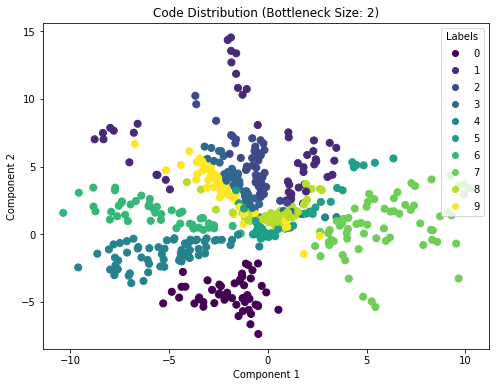

In [183]:
with torch.no_grad():
    val_data = val_dataset["X"]  # Choose a subset for visualization
    code_representation = autoencoder_2.encoder(val_data).numpy()

# Assuming you have labels for the validation data
labels = val_dataset["y"]  # Choose a subset for visualization

# Create a scatter plot with labels as colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    code_representation[:, 0], code_representation[:, 1], c=labels, cmap="viridis", s=50
)
plt.title(f"Code Distribution (Bottleneck Size: 2)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(*scatter.legend_elements(), title="Labels", loc="upper right")
plt.show()

The same labels are represented in a space in 2D where each label represents a distinct area